# Compulsory Assignment 2
Stian Teien og Kristian Riksheim, Gruppe 19

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import h5py
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
import kerastuner as kt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dat300-h2020-ca2/train.h5
/kaggle/input/dat300-h2020-ca2/sample_submission.csv
/kaggle/input/dat300-h2020-ca2/test.h5


## Prepare the data
Split the data and preprosses it to fit the models
* Train data
* Val data
* Standarize x and y

In [2]:
data = h5py.File('/kaggle/input/dat300-h2020-ca2/train.h5', 'r')
data_test = h5py.File('/kaggle/input/dat300-h2020-ca2/test.h5', 'r')
X_data = data['X'][:]
y_data = data['y'][:]
X_test = data_test['X'][:]

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=1)

del X_data, y_data, data

In [3]:
# Standrize
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)


X_train_centered = (X_train - mean_vals)/std_val
X_val_centered = (X_val - mean_vals)/std_val
X_test_centered = (X_test - mean_vals)/std_val

y_train /= 255
y_val /= 255

In [4]:
print(y_train.shape, X_test.shape)

(2400, 128, 128, 1) (500, 128, 128, 4)


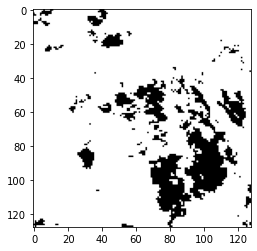

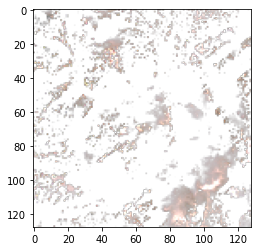

In [5]:
# Just get a look on of it is
plt.imshow(y_train[40].reshape(128,128), cmap="Greys")
plt.show()
plt.imshow(X_train_centered[40].reshape(128,128, 4))
plt.show()

# Show example on how to manipulate images
Here is an example on how we can manipulate the images done far below

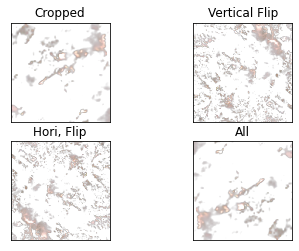

In [6]:
Example_img = X_train_centered[40]
cropped_img = tf.image.crop_to_bounding_box(Example_img, 50,20,64,64)
cropped_img = tf.image.resize(cropped_img, size=(128,128))

#Flip horizontal
hFlip_img = tf.image.flip_left_right(Example_img)

#Flip Vertical
vFlip_img = tf.image.flip_up_down(Example_img)

#All alterations
imc = tf.image.crop_to_bounding_box(Example_img, 50,20,64,64)
imr = tf.image.resize(imc, size=(128,128))
imvf = tf.image.flip_left_right(imr)
imAll = tf.image.flip_up_down(imvf)

f, axarr = plt.subplots(2,2)
#axarr[0,0].imshow(Example_img)
#axarr[0,0].set_title('Original')
axarr[0,0].imshow(cropped_img)
axarr[0,0].set_title('Cropped')
axarr[0,0].get_xaxis().set_visible(False)
axarr[0,0].get_yaxis().set_visible(False)
axarr[0,1].imshow(vFlip_img)
axarr[0,1].set_title('Vertical Flip')
axarr[0,1].get_xaxis().set_visible(False)
axarr[0,1].get_yaxis().set_visible(False)
axarr[1,0].imshow(hFlip_img)
axarr[1,0].set_title('Hori, Flip')
axarr[1,0].get_xaxis().set_visible(False)
axarr[1,0].get_yaxis().set_visible(False)
axarr[1,1].imshow(imAll)
axarr[1,1].set_title('All')
axarr[1,1].get_xaxis().set_visible(False)
axarr[1,1].get_yaxis().set_visible(False)

# Make an u-net
Sets up function to create an u-net based on dropouts and n_filters

In [7]:
"""
Version of U-Net with dropout and size preservation (padding= 'same')
""" 
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True, n_classes = 2):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model



def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [8]:
def make_model(n_filters, dropout, lr=0.001):
    input_img = Input(shape=(128,128,4))
    model = get_unet(input_img, n_filters = n_filters, dropout = dropout, batchnorm = True, n_classes = 1)

    model.compile(optimizer=Adam(learning_rate=lr),
                 loss='binary_crossentropy',
                 metrics=['accuracy', get_f1])
    
    return model

def train_model(model, epochs=25):
    history = model.fit(X_train_centered, y_train, batch_size=128, epochs=epochs, validation_data=(X_val_centered, y_val), verbose=0,
                        callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_get_f1', patience=5, mode='max', restore_best_weights=True)])

    return history, model

## Train the models
Train the models based on different hyperparameters

In [9]:
params = {'n_filters':[16, 32],
         'dropout': [.0, .2, 0.4],
         'lr':[0.01, 0.001]}

In [10]:
all_history = []
t_com = len(params['n_filters'])*len(params['dropout']*len(params['lr']))
wv = 1
print(f"total combinations: {t_com}")

for v,i in enumerate(params['n_filters']):
    for w,j in enumerate(params['dropout']):
        for vv, o in enumerate(params['lr']):
            print(f"Running this combo: n_filter:{i}, dropout:{j}, lr:{o} ...\t This is combo {wv} of {t_com}", end="\t")
            h, m = train_model( make_model(i, j, o) , 25)
            all_history.append([(i,j,o),h.history['val_get_f1']])
            print(f"... Done. Best f1 score: {max(h.history['val_get_f1'])}, at index: {np.argmax(h.history['val_get_f1'])}")
            wv += 1
            del h, m



total combinations: 12
Running this combo: n_filter:16, dropout:0.0, lr:0.01 ...	 This is combo 1 of 12	... Done. Best f1 score: 0.659976601600647, at index: 0
Running this combo: n_filter:16, dropout:0.0, lr:0.001 ...	 This is combo 2 of 12	... Done. Best f1 score: 0.9460943341255188, at index: 15
Running this combo: n_filter:16, dropout:0.2, lr:0.01 ...	 This is combo 3 of 12	... Done. Best f1 score: 0.9359297752380371, at index: 17
Running this combo: n_filter:16, dropout:0.2, lr:0.001 ...	 This is combo 4 of 12	... Done. Best f1 score: 0.9309929609298706, at index: 5
Running this combo: n_filter:16, dropout:0.4, lr:0.01 ...	 This is combo 5 of 12	... Done. Best f1 score: 0.9208672642707825, at index: 8
Running this combo: n_filter:16, dropout:0.4, lr:0.001 ...	 This is combo 6 of 12	... Done. Best f1 score: 0.9259072542190552, at index: 5
Running this combo: n_filter:32, dropout:0.0, lr:0.01 ...	 This is combo 7 of 12	... Done. Best f1 score: 0.9274929165840149, at index: 10
Runnin

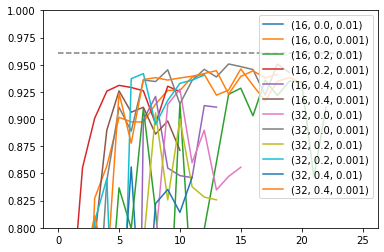

In [11]:
for i in all_history:
    plt.plot(i[1], label=i[0])

plt.ylim(0.8, 1)
plt.plot([0, 25],[.96112, .96112], '--', c="grey")
plt.legend()

In [12]:
# Remaking the best model
h, model = train_model( make_model(16, 0.0), 30 )

In [13]:
model.evaluate(X_val_centered, y_val, verbose=2)

19/19 - 1s - loss: 0.1271 - accuracy: 0.9532 - get_f1: 0.9515


[0.12708915770053864, 0.9531605243682861, 0.9514732360839844]

In [17]:
pred = model.predict(X_test_centered)

In [18]:
pred_flat = pred.flatten()
pred_df = pd.DataFrame(pred_flat,columns=['Predicted'])
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={'index':'Id'})

pp = [True if p > .5 else False for p in pred_df.Predicted]
pred_df.Predicted = pp
pred_df.to_csv('pred.csv', index=False)

## Ta en titt på distrubusjonen av svarene

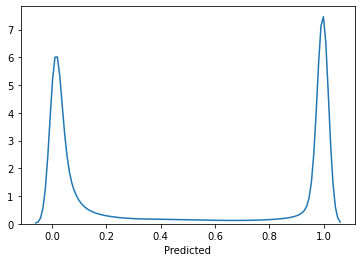

In [19]:
sns.distplot(pred_df.Predicted, hist=False)

# Neste steg blir å generere nye bilder

In [ ]:
datagen = ImageDataGenerator(zoom_range=0.1,
                            vertical_flip=True,
                            horizontal_flip=True)
datagen.fit(X_train_centered)
train_generator = datagen.flow(np.array(X_train_centered), np.array(y_train), 
                               batch_size=64)

In [ ]:
model = make_model(16, .0)

In [ ]:
history = model.fit(train_generator, batch_size=64, epochs=30, validation_data=(X_val_centered, y_val), verbose=2,
                        callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_get_f1', patience=5, mode='max', restore_best_weights=True)])
